In [1]:
!pip install pandas scikit-learn torch torchvision torchaudio transformers tqdm notebook
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.1 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 20.3 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.9/805.9 kB 4.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 17.0 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 2.8.0
    Uninstalling torch-2.8.0:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [torch]
      Successfully uninstalled torch-2.8.0━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [torch]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [torchaudio]4 [torchvision]
  Using cached contourpy-1.3.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 29.7 MB/s  0:00:00 eta 0:00:01
Using cached contourpy-1.3.2-cp310-cp310-maco

In [2]:
import pandas as pd

base = "dataverse_files/dataset/"

# Load each domain-label CSV
politifact_real = pd.read_csv(base + "politifact_real.csv")
politifact_fake = pd.read_csv(base + "politifact_fake.csv")
gossipcop_real = pd.read_csv(base + "gossipcop_real.csv")
gossipcop_fake = pd.read_csv(base + "gossipcop_fake.csv")

# Add domain and label columns
politifact_real["domain"], politifact_real["label"] = "politifact", 1
politifact_fake["domain"], politifact_fake["label"] = "politifact", 0
gossipcop_real["domain"], gossipcop_real["label"] = "gossipcop", 1
gossipcop_fake["domain"], gossipcop_fake["label"] = "gossipcop", 0

# Combine all into one DataFrame
df = pd.concat([politifact_real, politifact_fake, gossipcop_real, gossipcop_fake], ignore_index=True)

# Keep only title + text columns (adjust if names differ)
text_cols = [c for c in df.columns if "title" in c.lower() or "text" in c.lower()]
df = df[text_cols + ["domain", "label"]]
df = df.dropna(subset=text_cols)

print("✅ Combined dataset size:", len(df))
df.head()


✅ Combined dataset size: 23196


,title,domain,label
0,National Federation of Independent Business,politifact,1
1,comments in Fayetteville NC,politifact,1
2,"Romney makes pitch, hoping to close deal : Ele...",politifact,1
3,Democratic Leaders Say House Democrats Are Uni...,politifact,1
4,"Budget of the United States Government, FY 2008",politifact,1


In [3]:
df = df.drop_duplicates()
df["label"] = df["label"].astype(int)
df.to_csv("fakenewsnet_combined.csv", index=False)
print("Saved cleaned combined dataset as fakenewsnet_combined.csv")


✅ Saved cleaned combined dataset as fakenewsnet_combined.csv


In [4]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df, test_size=0.3, stratify=df[["domain","label"]], random_state=42)
val, test = train_test_split(temp, test_size=0.67, stratify=temp[["domain","label"]], random_state=42)

print("Train:", len(train), "Val:", len(val), "Test:", len(test))


Train: 15293 Val: 2163 Test: 4392


✅ TF-IDF matrix: 15293 docs, 12412 features
Classification Report:
              precision    recall  f1-score   support

           0      0.587     0.716     0.645      1070
           1      0.902     0.838     0.868      3322

    accuracy                          0.808      4392
   macro avg      0.744     0.777     0.757      4392
weighted avg      0.825     0.808     0.814      4392



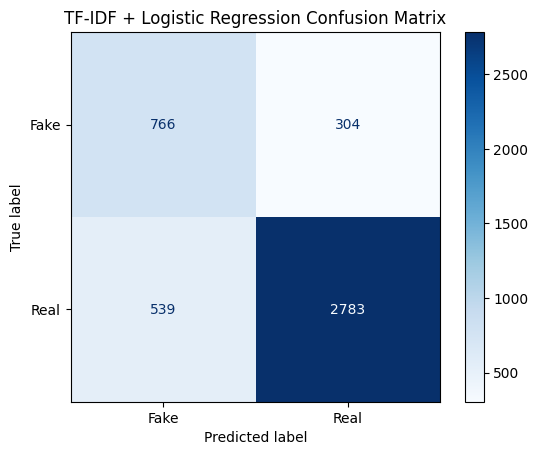


🟩 Top words predicting REAL news:
['best' 'season' 'awards' 'celebrates' 'beauty' 'style' 'shares' 'cardi'
 'dress' 'reveals' 'transcript' 'fan' 'bell' 'bachelor' 'thanks']

🟥 Top words predicting FAKE news:
['breaking' 'trump' 'react' 'caitlyn' 'brad' 'kanye' 'report' 'jenner'
 'pattinson' 'jennifer' 'pitt' 'beyonce' 'politifact' 'rihanna'
 'brad pitt']


In [5]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# -----------------------------
# 1. Text preprocessing
# -----------------------------
def clean_text(text):
    """
    Clean and normalize news text:
    - remove URLs, mentions, special chars
    - lowercase all text
    """
    text = re.sub(r"http\S+", "", text)             # remove URLs
    text = re.sub(r"@\w+", "", text)                # remove mentions
    text = re.sub(r"[^A-Za-z0-9\s']", " ", text)    # keep alphanumeric and spaces
    text = re.sub(r"\s+", " ", text)                # normalize whitespace
    return text.strip().lower()

# Combine title + body and clean
X_train = (train.iloc[:,0] + " " + train.iloc[:,1]).fillna("").apply(clean_text)
X_test  = (test.iloc[:,0] + " " + test.iloc[:,1]).fillna("").apply(clean_text)
y_train, y_test = train["label"], test["label"]

# -----------------------------
# 2. TF-IDF Vectorization
# -----------------------------
tfidf = TfidfVectorizer(
    ngram_range=(1,3),        # unigrams, bigrams, trigrams
    min_df=3,                 # ignore rare words
    max_df=0.9,               # ignore extremely common ones
    max_features=100000,      # expand vocabulary
    sublinear_tf=True,        # log-scale term frequency
    stop_words="english"      # remove stopwords
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

print(f"✅ TF-IDF matrix: {X_train_vec.shape[0]} docs, {X_train_vec.shape[1]} features")

# -----------------------------
# 3. Logistic Regression
# -----------------------------
clf = LogisticRegression(
    C=2,                      # slightly less regularization than default
    max_iter=300,
    class_weight="balanced",
    solver="liblinear"
)

clf.fit(X_train_vec, y_train)
pred = clf.predict(X_test_vec)

# -----------------------------
# 4. Evaluation
# -----------------------------
print("Classification Report:")
print(classification_report(y_test, pred, digits=3))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("TF-IDF + Logistic Regression Confusion Matrix")
plt.show()

# -----------------------------
# 5. Feature Importance (Top Words)
# -----------------------------
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]

top_real = np.argsort(coefs)[-15:]
top_fake = np.argsort(coefs)[:15]

print("\nTop words predicting REAL news:")
print(feature_names[top_real][::-1])

print("\nTop words predicting FAKE news:")
print(feature_names[top_fake])


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# --- 1. Prepare text and labels ---
def prepare_text(df):
    # Combine title and body into one string
    df["text"] = (df.iloc[:,0].fillna("") + " " + df.iloc[:,1].fillna("")).str.strip()
    return df[["text", "label"]]

train_df = prepare_text(train.copy())
val_df   = prepare_text(val.copy())
test_df  = prepare_text(test.copy())

# --- 2. Load tokenizer ---
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

# --- 3. Convert to Hugging Face Datasets ---
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# --- 4. Load model ---
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# --- 5. Training arguments ---
args = TrainingArguments(
    output_dir="./models",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100
)

# --- 6. Trainer setup ---
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer
)

# --- 7. Train ---
trainer.train()


/Users/macmimi/.pyenv/versions/3.10.11/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15293 [00:00<?, ? examples/s]

Map:   0%|          | 0/2163 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`